In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.preprocessing.image import ImageDataGenerator
import os


In [2]:
num_classes = 21
img_rows, img_cols = 64, 64
batch_size = 256


train_data_dir = '../input/latest-hindi-character/latest/Train'
validation_data_dir = '../input/latest-hindi-character/latest/Test'


trainDataGen = ImageDataGenerator(
		rotation_range = 8,
		width_shift_range = 0.1,
		height_shift_range = 0.1,
		rescale = 1.0/255,
		shear_range = 0.2,
		zoom_range = 0.2,		
		horizontal_flip = False,
		fill_mode = 'nearest',
)

test_datagen = ImageDataGenerator(rescale=1./255)
trainGenerator = trainDataGen.flow_from_directory(
			train_data_dir,
			target_size = (64,64),
			batch_size = 256,
			color_mode = "grayscale",
			class_mode = "categorical",
shuffle=True)
validation_generator = test_datagen.flow_from_directory(
			validation_data_dir,
			target_size=(64,64),
			batch_size=256,
			color_mode = "grayscale",
			class_mode= 'categorical',
shuffle=True)


Found 35700 images belonging to 21 classes.
Found 6300 images belonging to 21 classes.


In [3]:
model = Sequential()

# First CONV-ReLU Layer
model.add(Conv2D(64, (3, 3), padding = 'same', input_shape = (img_rows, img_cols,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Second CONV-ReLU Layer
model.add(Conv2D(64, (3, 3), padding = "same", input_shape = (img_rows, img_cols,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Max Pooling with Dropout 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 3rd set of CONV-ReLU Layers
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())

# 4th Set of CONV-ReLU Layers
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Max Pooling with Dropout 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 5th Set of CONV-ReLU Layers
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())

# 6th Set of CONV-ReLU Layers
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Max Pooling with Dropout 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# First set of FC or Dense Layers
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Second set of FC or Dense Layers
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Final Dense Layer
model.add(Dense(num_classes))
model.add(Activation("softmax"))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        640       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0

In [4]:
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

                     
checkpoint = ModelCheckpoint("./my_model.h5",
                             monitor="accuracy",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

reduce_lr = ReduceLROnPlateau(monitor = 'accuracy',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.00001)

# we put our call backs into a callback list
callbacks = [checkpoint, reduce_lr]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr=0.01),
              metrics = ['accuracy'])

nb_train_samples = 35700
nb_validation_samples = 6300 
epochs = 25

history = model.fit_generator(
    trainGenerator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
139/139 [==============================] - 117s 814ms/step - loss: 2.0949 - accuracy: 0.4181 - val_loss: 57.1639 - val_accuracy: 0.0485

Epoch 00001: accuracy improved from -inf to 0.59951, saving model to ./my_model.h5
Epoch 2/25
139/139 [==============================] - 49s 349ms/step - loss: 0.5040 - accuracy: 0.8402 - val_loss: 9.8493 - val_accuracy: 0.1204

Epoch 00002: accuracy improved from 0.59951 to 0.86895, saving model to ./my_model.h5
Epoch 3/25
139/139 [==============================] - 48s 344ms/step - loss: 0.2631 - accuracy: 0.9171 - val_loss: 0.2125 - val_accuracy: 0.9320

Epoch 00003: accuracy improved from 0.86895 to 0.92238, saving model to ./my_model.h5
Epoch 4/25
139/139 [==============================] - 48s 347ms/step - loss: 0.1797 - accuracy: 0.9436 - val_loss: 0.4639 - val_accuracy: 0.8797

Epoch 00004: accuracy improved from 0.92238 to 0.94560, saving model to ./my_model.h5
Epoch 5/25
139/139 [==============================] - 48s 342ms/step - lo

In [5]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss= history.history['val_loss']


In [ ]:
trainGenerator.class_indices

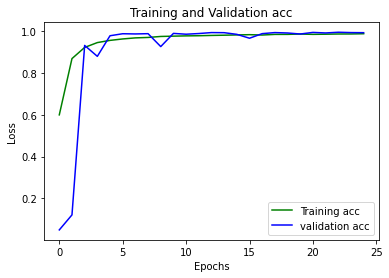

In [9]:
import matplotlib.pyplot as plt
epochs = range(0,25)
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()